In [1]:
import os
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import shutil
import time
import io
import random
import json

import tqdm.auto as tqdm
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import PIL.Image
import h5py

import datasets

## load data & interpolate

In [3]:
data_folder = './yume-nikki-data/video_0041/'
frame_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.startswith('frame_') and f.endswith('.jpg')]
actions_info = dict()
with open(os.path.join(data_folder, 'actions.json'), 'r') as f:
    actions_info = json.load(f)

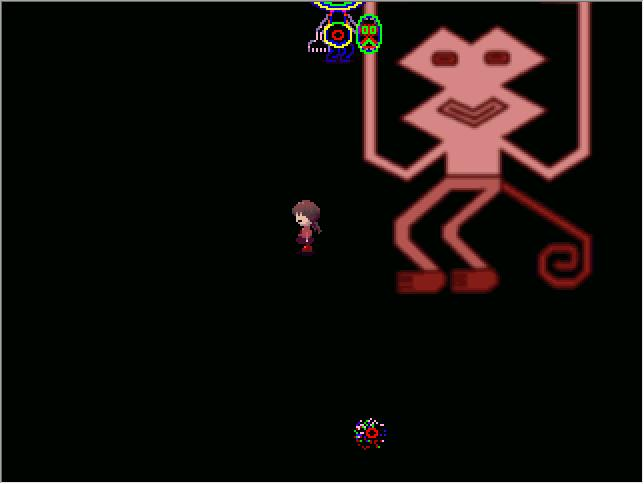

In [4]:
PIL.Image.open(random.choice(frame_files))

In [5]:
delta_t = [v['elapsed'] for v in actions_info.values()]
global_fps = 1. / np.mean(delta_t)
duration = np.sum(delta_t)
global_fps, duration

(np.float64(29.318015223032695), np.float64(6821.778298377991))

In [6]:
delta_t[0] = .0
timestamps = np.cumsum(delta_t)
target_fps = 12.
target_timeline = np.linspace(0., duration, int(duration * target_fps), endpoint=True)
selected_frames = np.zeros((target_timeline.shape), dtype=int)
for i, t in enumerate(target_timeline):
    time_idx = np.searchsorted(timestamps, t)
    if time_idx < 0:
        time_idx = 0
    if time_idx >= len(timestamps):
        time_idx = len(timestamps) - 1
    selected_frames[i] = time_idx

len(timestamps), len(target_timeline)

(200001, 81861)

In [7]:
random.choice(list(actions_info.keys()))

'88764'

In [8]:
timestamps[:10]

array([0.        , 0.28284001, 0.86708713, 1.14865422, 1.31296706,
       1.48892522, 1.6656661 , 1.72003126, 1.80770874, 1.86989713])

In [9]:
target_timeline[:10]

array([0.        , 0.0833347 , 0.16666939, 0.25000409, 0.33333879,
       0.41667349, 0.50000818, 0.58334288, 0.66667758, 0.75001227])

In [10]:
selected_frames[10000:10100]

array([15890, 15891, 15892, 15894, 15895, 15897, 15898, 15899, 15901,
       15902, 15903, 15904, 15906, 15907, 15909, 15910, 15912, 15913,
       15915, 15916, 15918, 15919, 15921, 15923, 15924, 15926, 15927,
       15929, 15930, 15931, 15933, 15934, 15936, 15938, 15940, 15941,
       15942, 15944, 15946, 15947, 15949, 15951, 15952, 15954, 15955,
       15956, 15957, 15958, 15959, 15961, 15962, 15964, 15965, 15967,
       15968, 15969, 15970, 15971, 15972, 15973, 15974, 15975, 15977,
       15979, 15980, 15982, 15983, 15985, 15986, 15988, 15990, 15991,
       15993, 15994, 15996, 15998, 16000, 16001, 16003, 16004, 16006,
       16008, 16010, 16011, 16013, 16014, 16015, 16017, 16019, 16021,
       16022, 16024, 16026, 16028, 16029, 16031, 16032, 16034, 16035,
       16037])

In [11]:
selected_frames.shape, np.diff(selected_frames).shape

((81861,), (81860,))

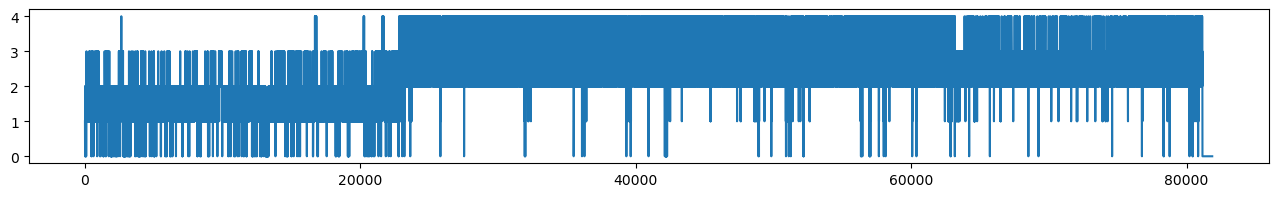

In [12]:
from IPython.display import display

fig = plt.figure(figsize=(16, 2))
plt.plot(np.diff(selected_frames))
display(fig)
plt.close(fig)

In [13]:
reduced_selected_frames = selected_frames[np.where(np.diff(selected_frames) != 0)[0]]
reduced_selected_frames.shape

(80452,)

## create dataset

In [13]:
9 // 10

0

In [14]:
h5file = None
action_map = dict(
    Left=0, Up=1, Down=2, Right=3, z=4,
)
action_matrix = np.eye(len(action_map))
for i, frame_index in tqdm.tqdm(enumerate(selected_frames), total=len(selected_frames) // 1000 * 1000):
    h5filename = os.path.join(data_folder, f'framebatch_{i // 1000}.hdf5')
    if i % 1000 == 0:
        if h5file is not None:
            print('wrote', h5filename)
            h5file.close()
        if i // 1000 + 1 == len(selected_frames) // 1000:
            break
        h5file = h5py.File(h5filename, 'w')	
        frames = []
        actions = []
        
    frame_path = os.path.join(data_folder, f'frame_{frame_index:06d}.jpg')
    frame_rgb = np.array(PIL.Image.open(frame_path).resize((320, 240)))
    h5file.create_dataset(f"frame_{i % 1000}_x", data=frame_rgb[:,:,::-1])
    keys = actions_info[str(frame_index)]['keys']
    action = np.zeros((len(action_map)))
    for k in keys:
        if k in action_map:
            action += action_matrix[action_map[k]]
    h5file.create_dataset(f"frame_{i % 1000}_y", data=action.tolist())
if h5file is not None:
    h5file.close()

  0%|          | 0/81000 [00:00<?, ?it/s]

wrote ./yume-nikki-data/video_0041/framebatch_1.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_2.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_3.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_4.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_5.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_6.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_7.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_8.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_9.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_10.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_11.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_12.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_13.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_14.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_15.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_16.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_17.hdf5
wrote ./yume-nikki-data/video_0041/framebatch_18.hdf5
wrote ./yume-nikki-data/video_0041/fr

## Upload to huggingface

**NOTE** that the processing script expects folder/file.tar.gz so that file.tar.gz contains folder/files.hdf5

For that reason, better use the script below:

In [142]:
!~/.cargo/bin/bat preprocess_data.sh

───────┬────────────────────────────────────────────────────────────────────────
       │ File: preprocess_data.sh
───────┼────────────────────────────────────────────────────────────────────────
   1   │ #!/usr/bin/env bash
   2   │ 
   3   │ set -ex
   4   │ 
   5   │ if test -e "./yn-processed"; then
   6   │   rm -rf "./yn-processed/"
   7   │ fi
   8   │ 
   9   │ if ! test -e "./YN/YN.tar.gz"; then
  10   │   mkdir -p ./YN/
  11   │   for hdf5_file in ./yume-nikki-data/video_0041/framebatch_{1..79}.hdf5
       │ ; do
  12   │     if ! test -e "./YN/$(basename "$hdf5_file")"; then
  13   │       cp -v "$hdf5_file" ./YN/
  14   │     fi
  15   │   done
  16   │   tar czf "./YN/YN.tar.gz" ./YN/*.hdf5
  17   │   rm -vf ./YN/*.hdf5
  18   │ fi
  19   │ 
  20   │ python ./AI-MarioKart64/diamond/src/process_dataset_hdf5.py ./YN ./yn-p
       │ rocessed
───────┴────────────────────────────────────────────────────────────────────────


And the rest of this section is legacy.

## load dataset

In [15]:
ds = datasets.load_dataset("theoden8/DIAMOND-yume-nikki")

Generating test split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [133]:
ds.keys()

dict_keys(['train', 'test'])

In [134]:
ds_train = ds['train']
ds_train.column_names

['hdf5']

In [135]:
sample = random.choice(ds_train)

In [136]:
print(type(sample), sample.keys())
[len(sample[k]) for k in sample.keys()]

<class 'dict'> dict_keys(['hdf5'])


[231211896]

In [137]:
hdf = io.BytesIO(sample['hdf5'])

In [138]:
with h5py.File(hdf, 'r') as f:
    print('keys:', len(f.keys()))
    keys = list(f.keys())
    print('e.g.', sorted(keys, key=lambda k: int(k.split('_')[1]))[:10])
    n = random.randint(0, 1000)
    x_data, y_data = f[f'frame_{n}_x'][:], f[f'frame_{n}_y'][:]

keys: 2000
e.g. ['frame_0_x', 'frame_0_y', 'frame_1_x', 'frame_1_y', 'frame_2_x', 'frame_2_y', 'frame_3_x', 'frame_3_y', 'frame_4_x', 'frame_4_y']


frame 521
action [0. 0. 0. 1. 0.]


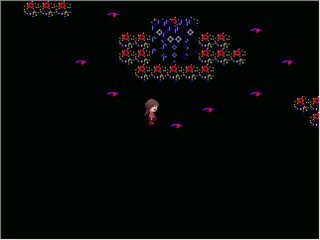

In [139]:
print('frame', n)
print('action', y_data)
display(PIL.Image.fromarray(x_data[:,:,::-1]))